# Tableau Agent

This is a sample implementation of a Langgraph Agent for Tableau.

In [1]:
import os

from dotenv import load_dotenv

from IPython.display import display, Markdown

from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

from agents.cra.state import CustomState
from agents.cra.tooling import tools
from agents.cra.memory import initialize_memory
from agents.utils.agent_utils import  _visualize_graph
from agents.utils.tableau import authenticate_tableau_user

/Users/s.price/miniconda/envs/tableau_langchain/lib/python3.12/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# environment variables available to current process and sub processes
load_dotenv()

domain = os.environ['TABLEAU_DOMAIN']
site = os.environ['TABLEAU_SITE']
datasource_luid = os.environ['DATASOURCE_LUID']

# define required authorizations to Tableau resources to support Agent operations
access_scopes = [
    "tableau:content:read", # for quering Tableau Metadata API
    "tableau:viz_data_service:read" # for querying VizQL Data Service
]

# get a valid Tableau session or API key
tableau_session = await authenticate_tableau_user(
    jwt_client_id=os.environ['TABLEAU_JWT_CLIENT_ID'],
    jwt_secret_id=os.environ['TABLEAU_JWT_SECRET_ID'],
    jwt_secret=os.environ['TABLEAU_JWT_SECRET'],
    tableau_api=os.environ['TABLEAU_API'],
    tableau_user=os.environ['TABLEAU_USER'],
    tableau_domain=domain,
    tableau_site=site,
    scopes=access_scopes
)

# inputs for Agent initialization, only credentials are mandatory
sample_inputs = {
    'tableau_credentials': {
        "session": tableau_session,
        "url": domain,
        "site": site,
    },
    'datasource': {
        "luid": datasource_luid,
        "name": None,
        "description": None
    }
}

Agent Graph saved as 'graph_visualization.png' | file size: 7650 bytes


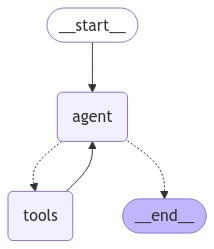

In [3]:
# configure running model for the agent
llm = ChatOpenAI(
    model=os.environ["AGENT_MODEL"],
    api_key=os.environ["OPENAI_API_KEY"],
    temperature=0,
    verbose=True,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

# initialize memory
memory = initialize_memory(memory_inputs=sample_inputs)

# set agent debugging state
if os.getenv('DEBUG') == '1':
    debugging = True
else:
    debugging = False

# define the agent graph
cra_agent = create_react_agent(
    model=llm,
    state_schema=CustomState,
    tools=tools,
    store=memory,
    debug=debugging
)

# outputs a mermaid diagram of the graph in png format
_visualize_graph(cra_agent)

In [6]:
# question or task sent to the agent
message_string = 'show me average discount, total sales and profits by region sorted by profit'

# graph inputs must follow dict[str, Any] | Any
input_stream = {
    "messages": [("user", message_string)],
}

# streams events from the Agent graph started by user input stream
for event in cra_agent.stream(input_stream):
    agent_output = event.get('agent')
    if event.get('agent'):
        agent_message = agent_output["messages"][0].content
        if len(agent_message) > 0:
            display(Markdown(agent_message))


Agent:
Ok
First I'll get as much metadata as I can about this data source...
I'll index field values so I can filter the data according to your specifications...
I have the necessary metadata and will write an API query for you


Here are the average discount, total sales, and profits by region, sorted by profit:

| Region  | Average Discount | Total Sales  | Total Profit  |
|---------|------------------|--------------|---------------|
| West    | 0.11             | 739,813.61   | 110,798.82    |
| East    | 0.14             | 691,828.17   | 94,883.26     |
| South   | 0.15             | 391,721.91   | 46,749.43     |
| Central | 0.24             | 503,170.67   | 39,865.31     |

The West region has the highest profit, followed by the East, South, and Central regions.